# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: Classify Gaussian blurs
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202210

In [36]:
# import libraries
import numpy as np
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\lucan\AppData\Local\Temp\ipykernel_16280\116190656.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [37]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

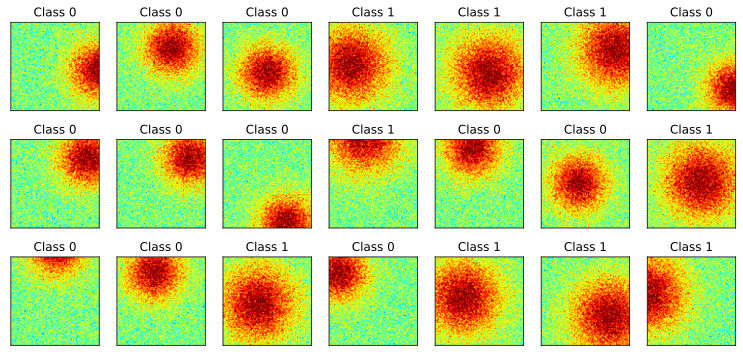

In [38]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Move to GPU

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Create train/test groups using DataLoader

In [40]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images.to(device), labels.to(device), test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [41]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [68]:
# create a class for the model
def makeTheNet(n_units: int):

  class gausnet(nn.Module):
    def __init__(self, n_units: int):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,6,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45

          nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22

          nn.Flatten(),                # vectorize conv output

          # FC1 2x input size
          nn.Linear(22*22*4, 2 * n_units),
          nn.ReLU(),

          # FC2 1x input size
          nn.Linear(2 * n_units, n_units),
          # nn.ReLU(),                  # Not sure why we don't want this. Probably does not matter much

          nn.Linear(n_units,1),             # output size: 1
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet(n_units).to(device)
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(), lr=.001)

  return net,lossfun,optimizer

In [69]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(5)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.7368, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [70]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 10]          19,370
              ReLU-9                   [-1, 10]               0
           Linear-10                    [-1, 5]              55
           Linear-11                    [-1, 1]               6
Total params: 19,711
Trainable params: 19,711
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/ba

# Create a function that trains the model

In [71]:
# a function that trains the model

# number of epochs
numepochs = 10

def function2trainTheModel(n_units: int):
  
  # create a new model
  net,lossfun,optimizer = makeTheNet(n_units)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [75]:
number_of_units = np.linspace(5, 500, 20).astype(int)

losses = {
  "training": np.zeros(len(number_of_units)),
  "testing": np.zeros(len(number_of_units)),
}

accuracies = {
  "training": np.zeros(len(number_of_units)),
  "testing": np.zeros(len(number_of_units)),
}

for i, n_units in enumerate(number_of_units):

  print(f"[{i+1}/{len(number_of_units)}] with {n_units} units")

  trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel(n_units)

  losses["training"][i] = np.mean(trainLoss[-1].detach().numpy())
  losses["testing"][i] = np.mean(testLoss[-1].detach().numpy())

  accuracies["training"][i] = np.mean(trainAcc[-1].detach().numpy())
  accuracies["testing"][i] = np.mean(testAcc[-1].detach().numpy())


[1/20] with 5 units
[2/20] with 31 units
[3/20] with 57 units
[4/20] with 83 units
[5/20] with 109 units
[6/20] with 135 units
[7/20] with 161 units
[8/20] with 187 units
[9/20] with 213 units
[10/20] with 239 units
[11/20] with 265 units
[12/20] with 291 units
[13/20] with 317 units
[14/20] with 343 units
[15/20] with 369 units
[16/20] with 395 units
[17/20] with 421 units
[18/20] with 447 units
[19/20] with 473 units
[20/20] with 500 units


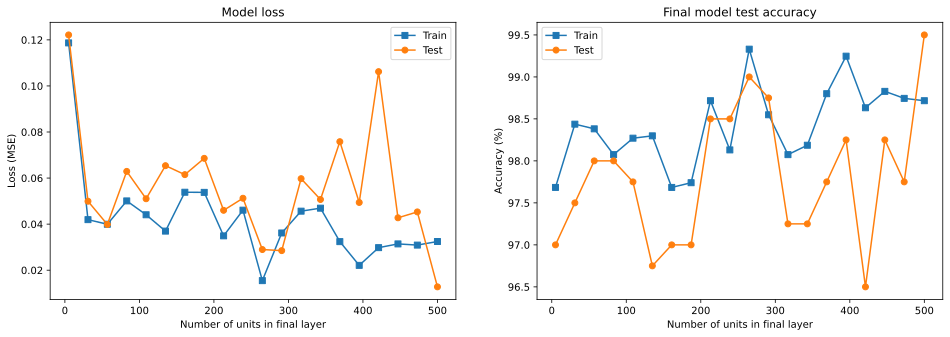

In [74]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(number_of_units, losses["training"],'s-',label='Train')
ax[0].plot(number_of_units, losses["testing"],'o-',label='Test')
ax[0].set_xlabel('Number of units in final layer')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(number_of_units, accuracies["training"],'s-',label='Train')
ax[1].plot(number_of_units, accuracies["testing"],'o-',label='Test')
ax[1].set_xlabel('Number of units in final layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy')
ax[1].legend()

plt.show()